<a href="https://colab.research.google.com/github/i-mein/AV-AmExpert-2019-Hackathon/blob/master/OpenVaccine_LSTM_GRU_mix_18092020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stanford mRNA Degradation Predictor


<H3> Solving the task challenge of mRNA Vaccine Degradation Predictor the RNA Base Pairs </H3>  

Special thanks to Tucker Arrants. The set of codes were collected from his notebook mentioned below.  
https://www.kaggle.com/tuckerarrants/openvaccine-gru-lstm



<h3> Importing the Libraries </h3>

In [1]:
!pip install -q kaggle
!pip install tensorflow_addons==0.10.0

     |████████████████████████████████| 1.1MB 2.7MB/s 
  Found existing installation: tensorflow-addons 0.8.3
    Uninstalling tensorflow-addons-0.8.3:
      Successfully uninstalled tensorflow-addons-0.8.3


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"imeintanis","key":"bca11de3b28899cbe039c95d21bcd94b"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c 'stanford-covid-vaccine'

  0% 0.00/89.6k [00:00<?, ?B/s]
100% 89.6k/89.6k [00:00<00:00, 32.7MB/s]
  0% 0.00/89.6k [00:00<?, ?B/s]
100% 89.6k/89.6k [00:00<00:00, 92.5MB/s]
  0% 0.00/89.6k [00:00<?, ?B/s]
100% 89.6k/89.6k [00:00<00:00, 82.8MB/s]
  0% 0.00/132k [00:00<?, ?B/s]
100% 132k/132k [00:00<00:00, 43.2MB/s]
  0% 0.00/89.6k [00:00<?, ?B/s]
100% 89.6k/89.6k [00:00<00:00, 97.5MB/s]
  0% 0.00/89.6k [00:00<?, ?B/s]
100% 89.6k/89.6k [00:00<00:00, 78.7MB/s]
  0% 0.00/132k [00:00<?, ?B/s]
100% 132k/132k [00:00<00:00, 41.9MB/s]
  0% 0.00/132k [00:00<?, ?B/s]
100% 132k/132k [00:00<00:00, 43.8MB/s]
  0% 0.00/132k [00:00<?, ?B/s]
100% 132k/132k [00:00<00:00, 120MB/s]
  0% 0.00/132k [00:00<?, ?B/s]
100% 132k/132k [00:00<00:00, 121MB/s]
  0% 0.00/132k [00:00<?, ?B/s]
100% 132k/132k [00:00<00:00, 121MB/s]
  0% 0.00/132k [00:00<?, ?B/s]
100% 132k/132k [00:00<00:00, 113MB/s]
  0% 0.00/132k [00:00<?, ?B/s]
100% 132k/132k [00:00<00:00, 132MB/s]
  0% 0.00/132k [00:00<?, ?B/s]
100% 132k/132k [00:00<00:00, 121MB/s]
  0% 0.00/8

In [4]:
# 
import pandas as pd, numpy as np
import math, json, gc, random, os, sys
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Deep Learning Libraries
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
import tensorflow_addons as tfa

import warnings
warnings.filterwarnings('ignore')
# Library for model evaluation
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, RepeatedStratifiedKFold

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.3.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [5]:

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    
    
SEED = 731    
seed_everything(SEED)

In [63]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true-y_pred)**2))

def cwrmse_metric(y_true, y_pred):

    e0 = rmse(y_true[:,0], y_pred[:,0])
    e1 = rmse(y_true[:,1], y_pred[:,1])
    e2 = rmse(y_true[:,3], y_pred[:,3])

    return np.mean([e0, e1, e2])

In [6]:
def post_process(public_preds, private_preds):
    
    preds_ls = []
    for df, preds in [(public_df, public_preds), (private_df, private_preds)]:
        for i, uid in enumerate(df.id):
            single_pred = preds[i]

            single_df = pd.DataFrame(single_pred, columns=target_cols)
            single_df['id_seqpos'] = [f'{uid}_{x}' for x in range(single_df.shape[0])]

            preds_ls.append(single_df)

    preds_df = pd.concat(preds_ls)
    return preds_df

token2int = {x:i for i, x in enumerate('().ACGUBEHIMSX')}

def preprocess_inputs(df, cols=['sequence', 'structure', 'predicted_loop_type']):
    return np.transpose(np.array(df[cols].applymap(lambda seq: [token2int[x] for x in seq]).values.tolist()),(0, 2, 1))

In [7]:
COLAB = True

FOLDS = 6
epoch = 200
VERBOSE = 0

FILTER_SNR = True

<h3> Getting the data with some basic EDA </h3>

In [8]:
PATH = './' if COLAB else '/kaggle/input/stanford-covid-vaccine/'

train = pd.read_json(PATH+'train.json.zip', lines=True)
test = pd.read_json(PATH+'test.json.zip', lines=True)
sample_df = pd.read_csv(PATH+'sample_submission.csv.zip')

target_cols = ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']

In [9]:
if FILTER_SNR:
    train = train[train.signal_to_noise > 1]

train_inputs = preprocess_inputs(train)
train_labels = np.array(train[target_cols].values.tolist()).transpose((0, 2, 1))

In [10]:
train.head()

,index,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,deg_error_Mg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...","[0.26130000000000003, 0.38420000000000004, 0.1...","[0.2631, 0.28600000000000003, 0.0964, 0.1574, ...","[0.1501, 0.275, 0.0947, 0.18660000000000002, 0...","[0.2167, 0.34750000000000003, 0.188, 0.2124, 0...","[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000..."
2,2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...","[0.1365, 0.2237, 0.1812, 0.1333, 0.1148, 0.160...","[0.17020000000000002, 0.178, 0.111, 0.091, 0.0...","[0.1033, 0.1464, 0.1126, 0.09620000000000001, ...","[0.14980000000000002, 0.1761, 0.1517, 0.116700...","[0.44820000000000004, 1.4822, 1.1819, 0.743400...","[0.2504, 1.4021, 0.9804, 0.49670000000000003, ...","[2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...","[0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...","[0.9501000000000001, 1.7974999999999999, 1.499..."
5,5,id_00ab2d761,GGAAAGCGCCGCGGCGGUAGCGGCAGCGAGGAGCGCUACCAAGGCA...,.....(.(((((.(((((((((...........)))))))..(((....,EEEEESISSSSSISSSSSSSSSHHHHHHHHHHHSSSSSSSMMSSSH...,4.136,1,107,68,"[0.1942, 0.2041, 0.1626, 0.1213, 0.10590000000...","[0.2726, 0.2984, 0.21660000000000001, 0.1637, ...","[0.3393, 0.2728, 0.2005, 0.1703, 0.1495, 0.134...","[0.165, 0.20520000000000002, 0.179, 0.1333, 0....","[0.2864, 0.24710000000000001, 0.2222, 0.1903, ...","[0.7642, 1.6641, 1.0622, 0.5008, 0.4107, 0.133...","[0.9559000000000001, 1.9442, 1.0114, 0.5105000...","[1.9554, 2.1298, 1.0403, 0.609, 0.5486, 0.386,...","[0.22460000000000002, 1.7281, 1.381, 0.6623, 0...","[0.5882000000000001, 1.1786, 0.9704, 0.6035, 0..."
6,6,id_00abef1d7,GGAAAACAAUUGCAUCGUUAGUACGACUCCACAGCGUAAGCUGUGG...,.........((((((((......((((((((((((....)))))))...,EEEEEEEEESSSSSSSSIIIIIISSSSSSSSSSSSHHHHSSSSSSS...,2.485,1,107,68,"[0.422, 0.5478000000000001, 0.4749000000000000...","[0.4801, 0.7943, 0.42160000000000003, 0.397300...","[0.9822000000000001, 1.272, 0.6940000000000001...","[0.5827, 0.7555000000000001, 0.5949, 0.4511, 0...","[0.9306000000000001, 1.0496, 0.5844, 0.7796000...","[0.895, 2.3377, 2.2305, 2.003, 1.9006, 1.0373,...","[0.46040000000000003, 3.6695, 0.78550000000000...","[2.7711, 7.365, 1.6924000000000001, 1.43840000...","[1.073, 2.8604000000000003, 1.9936, 1.0273, 1....","[2.0964, 3.3688000000000002, 0.6399, 2.1053, 1..."
7,7,id_00b436dec,GGAAAUCAUCGAGGACGGGUCCGUUCAGCACGCGAAAGCGUCGUGA...,.....(((((((((((..(((((((((..((((....))))..)))...,EEEEESSSSSSSSSSSIISSSSSSSSSIISSSSHHHHSSSSIISSS...,1.727,1,107,68,"[0.4843, 0.5233, 0.4554, 0.43520000000000003, ...","[0.8719, 1.0307, 0.6649, 0.34500000000000003, ...","[0.7045, 0.7775000000000001, 0.5662, 0.4561, 0...","[0.384, 0.723, 0.4766, 0.30260000000000004, 0....","[0.7429, 0.9137000000000001, 0.480400000000000...","[1.1576, 1.5137, 1.3382, 1.5622, 1.2121, 0.295...","[1.6912, 5.2652, 2.3901, 0.45890000000000003, ...","[1.8641, 2.3767, 1.149, 1.0132, 0.9876, 0.0, 0...","[0.49060000000000004, 4.6339, 1.95860000000000...","[1.2852000000000001, 2.5460000000000003, 0.234..."


In [11]:
REG=0

In [12]:
# tf.keras.initializers

In [13]:
def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 


def MCRMSE(y_true, y_pred):
    colwise_mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=1)
    return tf.reduce_mean(tf.sqrt(colwise_mse), axis=1)


def gru_layer(hidden_dim, dropout):
    return tf.keras.layers.Bidirectional(
                                tf.keras.layers.GRU(hidden_dim,
                                dropout=dropout,
                                return_sequences=True,
                                kernel_initializer = 'orthogonal'))

def lstm_layer(hidden_dim, dropout):
    return tf.keras.layers.Bidirectional(
                                tf.keras.layers.LSTM(hidden_dim,
                                dropout=dropout,
                                return_sequences=True,
                                kernel_initializer = 'orthogonal'))
    

def build_model(gru=1,seq_len=107, pred_len=68, dropout=0.5, embed_dim=160, hidden_dim=384):
    
    inputs = tf.keras.layers.Input(shape=(seq_len, 3))

    embed = tf.keras.layers.Embedding(input_dim=len(token2int), output_dim=embed_dim)(inputs)
    reshaped = tf.reshape(embed, shape=(-1, embed.shape[1],  embed.shape[2] * embed.shape[3]))
    
    reshaped = tf.keras.layers.SpatialDropout1D(.2)(reshaped)
    
    
    
    if gru==0:
        hidden = gru_layer(hidden_dim, dropout)(reshaped)
        # hidden = tf.keras.layers.BatchNormalization()(hidden)
        hidden = gru_layer(hidden_dim, dropout)(hidden)
        # hidden = tf.keras.layers.BatchNormalization()(hidden)
        hidden = gru_layer(hidden_dim, dropout)(hidden)
        
    elif gru==1:
        hidden = gru_layer(hidden_dim, dropout)(reshaped)
        # hidden = tf.keras.layers.BatchNormalization()(hidden)
        hidden = gru_layer(hidden_dim, dropout)(hidden)
        # hidden = tf.keras.layers.BatchNormalization()(hidden)
        hidden = lstm_layer(hidden_dim, dropout)(hidden)
        
    elif gru==2:
        hidden = gru_layer(hidden_dim, dropout)(reshaped)
        # hidden = tf.keras.layers.BatchNormalization()(hidden)
        hidden = lstm_layer(hidden_dim, dropout)(hidden)
        # hidden = tf.keras.layers.BatchNormalization()(hidden)
        hidden = gru_layer(hidden_dim, dropout)(hidden)
        
    elif gru==3:
        hidden = gru_layer(hidden_dim, dropout)(reshaped)
        # hidden = tf.keras.layers.BatchNormalization()(hidden)
        hidden = lstm_layer(hidden_dim, dropout)(hidden)
        # hidden = tf.keras.layers.BatchNormalization()(hidden)
        hidden = lstm_layer(hidden_dim, dropout)(hidden)
        
    elif gru==4:
        hidden = lstm_layer(hidden_dim, dropout)(reshaped)
        # hidden = tf.keras.layers.BatchNormalization()(hidden)
        hidden = gru_layer(hidden_dim, dropout)(hidden)
        # hidden = tf.keras.layers.BatchNormalization()(hidden)
        hidden = gru_layer(hidden_dim, dropout)(hidden)
        
    elif gru==5:
        hidden = lstm_layer(hidden_dim, dropout)(reshaped)
        # hidden = tf.keras.layers.BatchNormalization()(hidden)
        hidden = gru_layer(hidden_dim, dropout)(hidden)
        # hidden = tf.keras.layers.BatchNormalization()(hidden)
        hidden = lstm_layer(hidden_dim, dropout)(hidden)
    
    elif gru==6:
        hidden = lstm_layer(hidden_dim, dropout)(reshaped)
        # hidden = tf.keras.layers.BatchNormalization()(hidden)
        hidden = lstm_layer(hidden_dim, dropout)(hidden)
        # hidden = tf.keras.layers.BatchNormalization()(hidden)
        hidden = gru_layer(hidden_dim, dropout)(hidden)
    
    elif gru==7:
        hidden = lstm_layer(hidden_dim, dropout)(reshaped)
        # hidden = tf.keras.layers.BatchNormalization()(hidden)
        hidden = lstm_layer(hidden_dim, dropout)(hidden)
        # hidden = tf.keras.layers.BatchNormalization()(hidden)
        hidden = lstm_layer(hidden_dim, dropout)(hidden)
        
    
    #only making predictions on the first part of each sequence
    truncated = hidden[:, :pred_len]
    
    out = tf.keras.layers.Dense(5, activation='linear')(truncated)

    model = tf.keras.Model(inputs=inputs, outputs=out)

    #some optimizers
    opt = tf.optimizers.Adam()
    #     opt = tfa.optimizers.RectifiedAdam()
    #     opt = tfa.optimizers.Lookahead(adam, sync_period=6)
    #     opt = tfa.optimizers.Lookahead(radam, sync_period=6)
    
    #model.compile(optimizer=adam, loss='mse')
    model.compile(optimizer=opt, loss=MCRMSE, loss_weights=[1, 1, 0, 1, 0])
    
    return model

In [14]:
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=0, mode='auto')
lr_c = ReduceLROnPlateau(verbose=0)

In [ ]:
def model_checkpoint(path):
    return tf.keras.callbacks.ModelCheckpoint(path, save_best_only=True, verbose=0)

In [15]:
kf = KFold(n_splits=FOLDS, shuffle=True,random_state=SEED)
# kf = RepeatedStratifiedKFold(FOLDS, n_repeats = 1, random_state=SEED)

# Training 

In [16]:
train_inputs_ = train_inputs
train_labels_ = train_labels
print(train_inputs_.shape,train_labels_.shape)

submissions_list = []

oof_gru = np.zeros((train_labels.shape))
oof_lstm = np.zeros((train_labels.shape))
oof_hyb1 = np.zeros((train_labels.shape))
oof_hyb2 = np.zeros((train_labels.shape))
oof_hyb3 = np.zeros((train_labels.shape))
oof_hyb4 = np.zeros((train_labels.shape))
oof_hyb5 = np.zeros((train_labels.shape))
oof_hyb6 = np.zeros((train_labels.shape))

for fold, (train_index, val_index) in enumerate(kf.split(train_inputs_,train_labels_)):

    print('-'*30)
    print(f"fold {fold} # train:{len(train_index)} # val:{len(val_index)}")
    print('-'*30)

    train_inputs = train_inputs_[train_index]
    train_labels = train_labels_[train_index]
    val_inputs   = train_inputs_[val_index]
    val_labels   = train_labels_[val_index]
    
    tf.keras.backend.clear_session()
    # -------------------------------------------------------------------------

    gru = build_model(gru=0)
    save_pth = 'model_gru.h5'
    
    history_gru = gru.fit(
        train_inputs, train_labels, 
        validation_data=(val_inputs,val_labels),
        batch_size=64,
        epochs=epoch,
        callbacks=[lr_c, es, model_checkpoint(save_pth)],
        verbose=VERBOSE)
    
    
    gru.load_weights(save_pth)
    val_pred = gru.predict(val_inputs)
    oof_gru[val_index] = val_pred
    print(val_pred.shape)

    print()
    print(f"MODEL 0: Train loss={min(history_gru.history['loss'])} / Valid loss={min(history_gru.history['val_loss'])}")
    # -------------------------------------------------------------------------

    lstm = build_model(gru=7)
    save_pth = 'model_lstm.h5'

    history_lstm = lstm.fit(
        train_inputs, train_labels, 
        validation_data=(val_inputs,val_labels),
        batch_size=64,
        epochs=epoch,
        callbacks=[lr_c,es, model_checkpoint(save_pth)],
        verbose=VERBOSE)

    lstm.load_weights(save_pth)
    val_pred = lstm.predict(val_inputs)
    oof_lstm[val_index] = val_pred
    print(val_pred.shape)


    print()
    print(f"MODEL 1: Train loss={min(history_lstm.history['loss'])} / Valid loss={min(history_lstm.history['val_loss'])}")
    # -------------------------------------------------------------------------

    hyb1 = build_model(gru=1)
    save_pth = 'model_hyb1.h5'

    history_hyb1 = hyb1.fit(
        train_inputs, train_labels, 
        validation_data=(val_inputs,val_labels),
        batch_size=64,
        epochs=epoch,
        callbacks=[lr_c, es, model_checkpoint(save_pth)],
        verbose=VERBOSE)

    hyb1.load_weights(save_pth)
    val_pred = hyb1.predict(val_inputs)
    oof_hyb1[val_index] = val_pred
    print(val_pred.shape)
    
    print()
    print(f"MODEL 2: Train loss={min(history_hyb1.history['loss'])} / Valid loss={min(history_hyb1.history['val_loss'])}")
    # -------------------------------------------------------------------------

    hyb2 = build_model(gru=2)
    save_pth = 'model_hyb2.h5'

    history_hyb2 = hyb2.fit(
        train_inputs, train_labels, 
        validation_data=(val_inputs,val_labels),
        batch_size=64,
        epochs=epoch,
        callbacks=[lr_c, es, model_checkpoint(save_pth)],
        verbose = VERBOSE)
    
    hyb2.load_weights(save_pth)
    val_pred = hyb2.predict(val_inputs)
    oof_hyb2[val_index] = val_pred
    print(val_pred.shape)
    
    print()
    print(f"MODEL 3: Train loss={min(history_hyb2.history['loss'])} / Valid loss={min(history_hyb2.history['val_loss'])}")
    # -------------------------------------------------------------------------

    hyb3 = build_model(gru=3)
    save_pth = 'model_hyb3.h5'

    history_hyb3 = hyb3.fit(
        train_inputs, train_labels, 
        validation_data=(val_inputs,val_labels),
        batch_size=64,
        epochs=epoch,
        callbacks=[lr_c,es, model_checkpoint(save_pth)],
        verbose=VERBOSE)
    
    hyb3.load_weights(save_pth)
    val_pred = hyb3.predict(val_inputs)
    oof_hyb3[val_index] = val_pred
    print(val_pred.shape)
    
    print()
    print(f"MODEL 4: Train loss={min(history_hyb3.history['loss'])} / Validation loss={min(history_hyb3.history['val_loss'])}")
    # -------------------------------------------------------------------------

    hyb4 = build_model(gru=4)
    save_pth = 'model_hyb4.h5'

    history_hyb4 = hyb4.fit(
        train_inputs, train_labels, 
        validation_data=(val_inputs,val_labels),
        batch_size=64,
        epochs=epoch,
        callbacks=[lr_c, es, model_checkpoint(save_pth)],
        verbose=VERBOSE)
    
    hyb4.load_weights(save_pth)
    val_pred = hyb4.predict(val_inputs)
    oof_hyb4[val_index] = val_pred
    print(val_pred.shape)

    print()
    print(f"MODEL 5: Train loss={min(history_hyb4.history['loss'])}/ Valid loss={min(history_hyb4.history['val_loss'])}")
    # -------------------------------------------------------------------------

    hyb5 = build_model(gru=5)
    save_pth = 'model_hyb5.h5'


    history_hyb5 = hyb5.fit(
        train_inputs, train_labels, 
        validation_data=(val_inputs,val_labels),
        batch_size=64,
        epochs=epoch,
        callbacks=[lr_c,es, model_checkpoint(save_pth)],
        verbose = VERBOSE)
        
    hyb5.load_weights(save_pth)
    val_pred = hyb5.predict(val_inputs)
    oof_hyb5[val_index] = val_pred
    print(val_pred.shape)

    print()
    print(f"MODEL 6: Train loss={min(history_hyb5.history['loss'])} / valid loss={min(history_hyb5.history['val_loss'])}")
    # -------------------------------------------------------------------------

    hyb6 = build_model(gru=6)
    save_pth = 'model_hyb6.h5'

    history_hyb6 = hyb6.fit(
        train_inputs, train_labels, 
        validation_data=(val_inputs,val_labels),
        batch_size=64,
        epochs=epoch,
        callbacks=[lr_c,es, model_checkpoint(save_pth)],
        verbose=VERBOSE)
    
    hyb6.load_weights(save_pth)
    val_pred = hyb6.predict(val_inputs)
    oof_hyb6[val_index] = val_pred
    print(val_pred.shape)


    print(f"MODEL 7: Train loss={min(history_hyb6.history['loss'])} / valid loss={min(history_hyb6.history['val_loss'])}")
    # =========================================================================

    public_df = test.query("seq_length == 107").copy()
    private_df = test.query("seq_length == 130").copy()

    public_inputs = preprocess_inputs(public_df)
    private_inputs = preprocess_inputs(private_df)


    # build all models
    print('> Build all models')
    gru_short = build_model(gru=0, seq_len=107, pred_len=107)
    gru_long = build_model(gru=0, seq_len=130, pred_len=130)
    lstm_short = build_model(gru=7, seq_len=107, pred_len=107)
    lstm_long = build_model(gru=7, seq_len=130, pred_len=130)
    hyb1_short = build_model(gru=1, seq_len=107, pred_len=107)
    hyb1_long = build_model(gru=1, seq_len=130, pred_len=130)
    hyb2_short = build_model(gru=2, seq_len=107, pred_len=107)
    hyb2_long = build_model(gru=2, seq_len=130, pred_len=130)
    hyb3_short = build_model(gru=3, seq_len=107, pred_len=107)
    hyb3_long = build_model(gru=3, seq_len=130, pred_len=130)
    hyb4_short = build_model(gru=4, seq_len=107, pred_len=107)
    hyb4_long = build_model(gru=4, seq_len=130, pred_len=130)
    hyb5_short = build_model(gru=5, seq_len=107, pred_len=107)
    hyb5_long = build_model(gru=5, seq_len=130, pred_len=130)
    hyb6_short = build_model(gru=6, seq_len=107, pred_len=107)
    hyb6_long = build_model(gru=6, seq_len=130, pred_len=130)


    # load pre-trained model weights
    gru_short.load_weights('model_gru.h5')
    gru_long.load_weights('model_gru.h5')
    lstm_short.load_weights('model_lstm.h5')
    lstm_long.load_weights('model_lstm.h5')
    hyb1_short.load_weights('model_hyb1.h5')
    hyb1_long.load_weights('model_hyb1.h5')
    hyb2_short.load_weights('model_hyb2.h5')
    hyb2_long.load_weights('model_hyb2.h5')
    hyb3_short.load_weights('model_hyb3.h5')
    hyb3_long.load_weights('model_hyb3.h5')
    hyb4_short.load_weights('model_hyb4.h5')
    hyb4_long.load_weights('model_hyb4.h5')
    hyb5_short.load_weights('model_hyb5.h5')
    hyb5_long.load_weights('model_hyb5.h5')
    hyb6_short.load_weights('model_hyb6.h5')
    hyb6_long.load_weights('model_hyb6.h5')


    # predict Test set
    print('> Predict Test set')
    gru_public_preds = gru_short.predict(public_inputs)
    gru_private_preds = gru_long.predict(private_inputs)
    lstm_public_preds = lstm_short.predict(public_inputs)
    lstm_private_preds = lstm_long.predict(private_inputs)
    hyb1_public_preds = hyb1_short.predict(public_inputs)
    hyb1_private_preds = hyb1_long.predict(private_inputs)
    hyb2_public_preds = hyb2_short.predict(public_inputs)
    hyb2_private_preds = hyb2_long.predict(private_inputs)
    hyb3_public_preds = hyb3_short.predict(public_inputs)
    hyb3_private_preds = hyb3_long.predict(private_inputs)
    hyb4_public_preds = hyb4_short.predict(public_inputs)
    hyb4_private_preds = hyb4_long.predict(private_inputs)
    hyb5_public_preds = hyb5_short.predict(public_inputs)
    hyb5_private_preds = hyb5_long.predict(private_inputs)
    hyb6_public_preds = hyb6_short.predict(public_inputs)
    hyb6_private_preds = hyb6_long.predict(private_inputs)
    
    
    # Post-process/flatten perdictions 
    preds_gru_df  = post_process(gru_public_preds, gru_private_preds)
    preds_lstm_df = post_process(lstm_public_preds, lstm_private_preds)
    preds_hyb1_df = post_process(hyb1_public_preds, hyb1_private_preds)
    preds_hyb2_df = post_process(hyb2_public_preds, hyb2_private_preds)
    preds_hyb3_df = post_process(hyb3_public_preds, hyb3_private_preds)
    preds_hyb4_df = post_process(hyb4_public_preds, hyb4_private_preds)
    preds_hyb5_df = post_process(hyb5_public_preds, hyb5_private_preds)
    preds_hyb6_df = post_process(hyb6_public_preds, hyb6_private_preds)
   

    print('> Blend Predictions')
    blend_preds_df = pd.DataFrame()
    blend_preds_df['id_seqpos']   = preds_gru_df['id_seqpos']
    blend_preds_df['reactivity']  = 0.2*preds_gru_df['reactivity']  + 0.2*preds_lstm_df['reactivity']  + 0.2*preds_hyb1_df['reactivity']  + 0.2*preds_hyb2_df['reactivity']  + 0.2*preds_hyb3_df['reactivity']  + 0.2*preds_hyb4_df['reactivity']  + 0.2*preds_hyb5_df['reactivity']  + 0.2*preds_hyb6_df['reactivity']
    blend_preds_df['deg_Mg_pH10'] = 0.2*preds_gru_df['deg_Mg_pH10'] + 0.2*preds_lstm_df['deg_Mg_pH10'] + 0.2*preds_hyb1_df['deg_Mg_pH10'] + 0.2*preds_hyb2_df['deg_Mg_pH10'] + 0.2*preds_hyb3_df['deg_Mg_pH10'] + 0.2*preds_hyb4_df['deg_Mg_pH10'] + 0.2*preds_hyb5_df['deg_Mg_pH10'] + 0.2*preds_hyb6_df['deg_Mg_pH10']
    blend_preds_df['deg_pH10']    = 0.2*preds_gru_df['deg_pH10']    + 0.2*preds_lstm_df['deg_pH10']    + 0.2*preds_hyb1_df['deg_pH10']    + 0.2*preds_hyb2_df['deg_pH10']    + 0.2*preds_hyb3_df['deg_pH10']    + 0.2*preds_hyb4_df['deg_pH10']    + 0.2*preds_hyb5_df['deg_pH10']    + 0.2*preds_hyb6_df['deg_pH10']
    blend_preds_df['deg_Mg_50C']  = 0.2*preds_gru_df['deg_Mg_50C']  + 0.2*preds_lstm_df['deg_Mg_50C']  + 0.2*preds_hyb1_df['deg_Mg_50C']  + 0.2*preds_hyb2_df['deg_Mg_50C']  + 0.2*preds_hyb3_df['deg_Mg_50C']  + 0.2*preds_hyb4_df['deg_Mg_50C']  + 0.2*preds_hyb5_df['deg_Mg_50C']  + 0.2*preds_hyb6_df['deg_Mg_50C']
    blend_preds_df['deg_50C']     = 0.2*preds_gru_df['deg_50C']     + 0.2*preds_lstm_df['deg_50C']     + 0.2*preds_hyb1_df['deg_50C']     + 0.2*preds_hyb2_df['deg_Mg_50C']  + 0.2*preds_hyb3_df['deg_Mg_50C']  + 0.2*preds_hyb4_df['deg_50C']     + 0.2*preds_hyb5_df['deg_Mg_50C']  + 0.2*preds_hyb6_df['deg_Mg_50C']

    blend_preds_df['reactivity']  /= 1.6
    blend_preds_df['deg_Mg_pH10'] /= 1.6
    blend_preds_df['deg_pH10']    /= 1.6
    blend_preds_df['deg_Mg_50C']  /= 1.6
    blend_preds_df['deg_50C']     /= 1.6

    sample_sub = pd.read_csv(PATH+'sample_submission.csv.zip')
    submission = sample_sub[['id_seqpos']].merge(blend_preds_df, on=['id_seqpos'])

    submission.head()

    # Saving the final output file
    submission.to_csv(f"submission_{fold}.csv", index=False)
    submissions_list.append(submission)
    

(2096, 107, 3) (2096, 68, 5)
------------------------------
fold 0 # train:1746 # val:350
------------------------------
Epoch 00138: early stopping
(350, 68, 5)

MODEL 0: Train loss=0.14080467820167542 / Valid loss=0.2185877114534378
Epoch 00101: early stopping
(350, 68, 5)

MODEL 1: Train loss=0.13197241723537445 / Valid loss=0.22287632524967194
Epoch 00095: early stopping
(350, 68, 5)

MODEL 2: Train loss=0.1338491290807724 / Valid loss=0.22006860375404358
Epoch 00095: early stopping
(350, 68, 5)

MODEL 3: Train loss=0.14870204031467438 / Valid loss=0.21920356154441833
Epoch 00102: early stopping
(350, 68, 5)

MODEL 4: Train loss=0.1306459754705429 / Validation loss=0.22109095752239227
Epoch 00108: early stopping
(350, 68, 5)

MODEL 5: Train loss=0.14277403056621552/ Valid loss=0.2180066853761673
Epoch 00100: early stopping
(350, 68, 5)

MODEL 6: Train loss=0.14194157719612122 / valid loss=0.21878455579280853
Epoch 00095: early stopping
(350, 68, 5)
MODEL 7: Train loss=0.14460824429

In [22]:
np.save('oof_gru_6kf.npy', oof_gru)
np.save('oof_lstm_6kf.npy', oof_lstm)
np.save('oof_hyb1_6kf.npy', oof_hyb1)
np.save('oof_hyb2_6kf.npy', oof_hyb2)
np.save('oof_hyb3_6kf.npy', oof_hyb3)
np.save('oof_hyb4_6kf.npy', oof_hyb4)
np.save('oof_hyb5_6kf.npy', oof_hyb5)
np.save('oof_hyb6_6kf.npy', oof_hyb6)

In [71]:
print('GRU OOF score:', cwrmse_metric(train_labels_, oof_gru))
print('LSTM OOF score:', cwrmse_metric(train_labels_, oof_lstm))
print('HYB-1 OOF score:', cwrmse_metric(train_labels_, oof_hyb1))
print('HYB-2 OOF score:', cwrmse_metric(train_labels_, oof_hyb2))
print('HYB-3 OOF score:', cwrmse_metric(train_labels_, oof_hyb3))
print('HYB-4 OOF score:', cwrmse_metric(train_labels_, oof_hyb4))
print('HYB-5 OOF score:', cwrmse_metric(train_labels_, oof_hyb5))
print('HYB-6 OOF score:', cwrmse_metric(train_labels_, oof_hyb6))

GRU OOF score: 0.38715209505195647
LSTM OOF score: 0.40943005882457323
HYB-1 OOF score: 0.4023845499066539
HYB-2 OOF score: 0.4006643689944834
HYB-3 OOF score: 0.40647814907638663
HYB-4 OOF score: 0.3948226998216686
HYB-5 OOF score: 0.40358108181841373
HYB-6 OOF score: 0.401594729596266


In [93]:
print('GRU OOF score:', cwrmse_metric(train_labels_, oof_gru*0.975))
print('LSTM OOF score:', cwrmse_metric(train_labels_, oof_lstm*0.975))
print('HYB-1 OOF score:', cwrmse_metric(train_labels_, oof_hyb1*0.975))
print('HYB-2 OOF score:', cwrmse_metric(train_labels_, oof_hyb2*0.975))
print('HYB-3 OOF score:', cwrmse_metric(train_labels_, oof_hyb3*0.975))
print('HYB-4 OOF score:', cwrmse_metric(train_labels_, oof_hyb4*0.975))
print('HYB-5 OOF score:', cwrmse_metric(train_labels_, oof_hyb5*0.975))
print('HYB-6 OOF score:', cwrmse_metric(train_labels_, oof_hyb6*0.975))

GRU OOF score: 0.3853373078993938
LSTM OOF score: 0.40576260753272836
HYB-1 OOF score: 0.39915883181320494
HYB-2 OOF score: 0.3973385786504277
HYB-3 OOF score: 0.4024628708216988
HYB-4 OOF score: 0.39220572454037583
HYB-5 OOF score: 0.39935047405358964
HYB-6 OOF score: 0.39849611008101427


In [58]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
files = []

for i in range(FOLDS):
    csv = pd.read_csv(f'./submission_{i}.csv')
    files.append(csv)

total = pd.concat(files, axis=1)
total.head()
col = list(submission.columns)[1:]
print(col)

submission1 = submission
for c in col:
    submission1[c] = total[c].mean(axis=1)
submission1.to_csv('submission_final.csv', index=False)
submission1.head()


['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']


,id_seqpos,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_00073f8be_0,0.764458,0.599759,1.988149,0.540229,0.678989
1,id_00073f8be_1,2.241800,3.117391,3.765055,3.153140,2.981395
2,id_00073f8be_2,1.548997,0.635365,0.606352,0.722454,0.714994
3,id_00073f8be_3,1.305761,1.153328,1.138116,1.649024,1.769328
4,id_00073f8be_4,0.811440,0.588739,0.460997,0.848880,0.882177


In [20]:
submission1.head()

,id_seqpos,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_00073f8be_0,0.764458,0.599759,1.988149,0.540229,0.678989
1,id_00073f8be_1,2.241800,3.117391,3.765055,3.153140,2.981395
2,id_00073f8be_2,1.548997,0.635365,0.606352,0.722454,0.714994
3,id_00073f8be_3,1.305761,1.153328,1.138116,1.649024,1.769328
4,id_00073f8be_4,0.811440,0.588739,0.460997,0.848880,0.882177


In [73]:
submission2 = submission1.copy()
submission2.reactivity = submission2.reactivity * 1.05
submission2.deg_Mg_pH10 = submission2.deg_Mg_pH10 * 1.05
submission2.deg_Mg_50C = submission2.deg_Mg_50C * 1.05

submission2.to_csv('submission_final_105.csv', index=False)

In [75]:
submission3 = submission1.copy()
submission3.reactivity = submission3.reactivity * 0.95
submission3.deg_Mg_pH10 = submission3.deg_Mg_pH10 * 0.95
submission3.deg_Mg_50C = submission3.deg_Mg_50C * 0.95

submission3.to_csv('submission_final_095.csv', index=False)

In [79]:
submission3.to_csv('submission_final_095.csv', index=False)

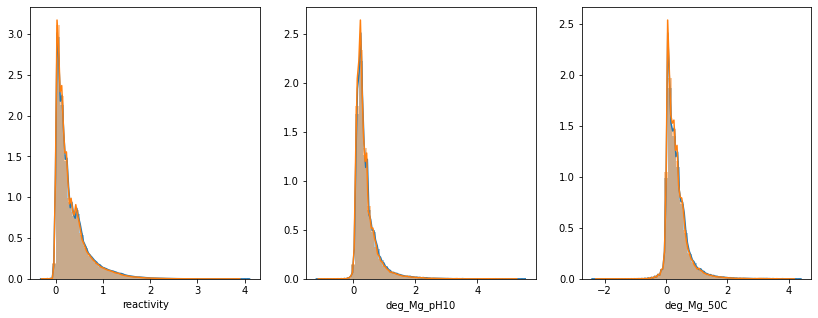

In [77]:
fig, ax = plt.subplots(1, 3, figsize=(14, 5))
sns.distplot(submission1.reactivity, ax=ax[0])
sns.distplot(submission1.deg_Mg_pH10, ax=ax[1])
sns.distplot(submission1.deg_Mg_50C, ax=ax[2])

sns.distplot(submission3.reactivity, ax=ax[0])
sns.distplot(submission3.deg_Mg_pH10, ax=ax[1])
sns.distplot(submission3.deg_Mg_50C, ax=ax[2])


In [26]:
train_inputs.shape, train_labels.shape

((1747, 107, 3), (1747, 68, 5))

In [25]:
submission1.shape

(457953, 6)

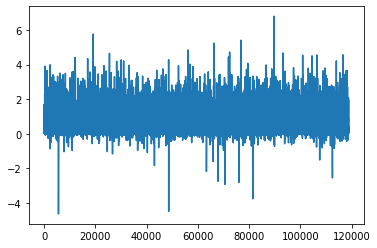

In [32]:
plt.figure()
plt.plot(train_labels[:,:,0].reshape(-1,1))
plt.title('reactivity')

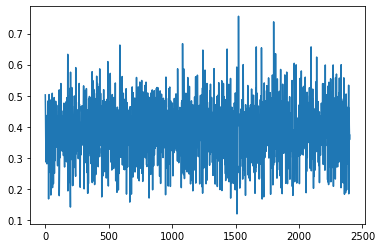

In [42]:
train.reactivity.apply(lambda s: np.mean(s)).plot()

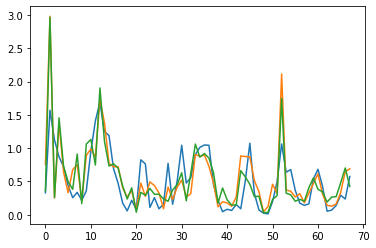

In [53]:
plt.plot(train.reactivity[0])
plt.plot(train.deg_Mg_pH10[0])
plt.plot(train.deg_Mg_50C[0])

In [55]:
train.reactivity

0       [0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...
2       [0.44820000000000004, 1.4822, 1.1819, 0.743400...
5       [0.7642, 1.6641, 1.0622, 0.5008, 0.4107, 0.133...
6       [0.895, 2.3377, 2.2305, 2.003, 1.9006, 1.0373,...
7       [1.1576, 1.5137, 1.3382, 1.5622, 1.2121, 0.295...
                              ...                        
2394    [0.3517, 0.5358, 0.4318, 0.016900000000000002,...
2395    [0.6957, 1.251, 1.3235999999999999, 0.7521, 0....
2396    [0.2891, 0.4496, 0.7165, 0.7128, 0.59310000000...
2398    [0.6919000000000001, 1.4823, 1.3685, 1.2473, 0...
2399    [1.0102, 1.7928000000000002, 1.9228, 0.9649000...
Name: reactivity, Length: 2096, dtype: object

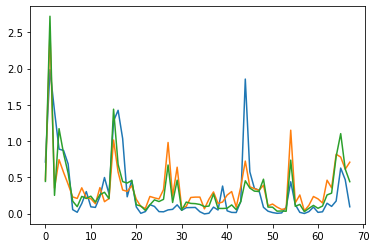

In [57]:
plt.plot(train.reactivity.iloc[10])
plt.plot(train.deg_Mg_pH10.iloc[10])
plt.plot(train.deg_Mg_50C.iloc[10])

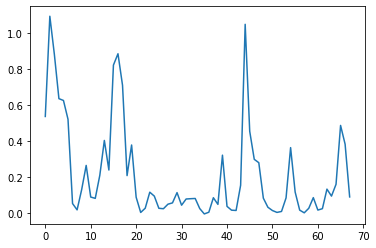

In [97]:
plt.plot(np.log1p(train.reactivity.iloc[10]))

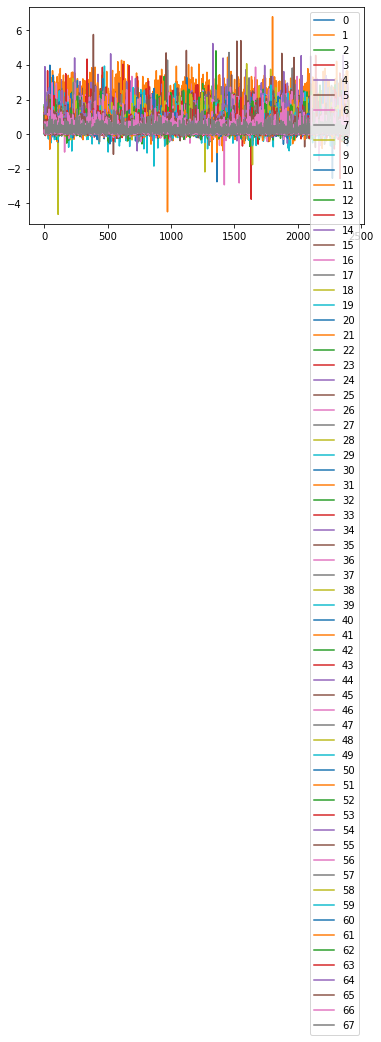

In [37]:
train.reactivity.apply(pd.Series).plot()

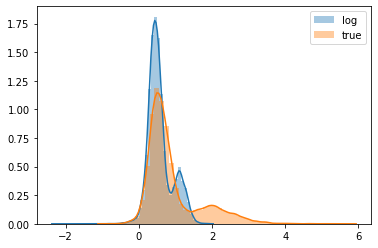

In [107]:
sns.distplot(np.log1p(train_labels_[:,0]), label='log')

sns.distplot(train_labels_[:,0],  label='true')
plt.legend()

(array([[  0.,   0.,   0.,   7., 159., 779., 843., 282.,  25.,   1.],
        [  0.,   0.,   0.,   2.,  66., 392., 775., 643., 206.,  12.],
        [  0.,   0.,   0.,   1.,   1.,  52., 472., 987., 515.,  68.],
        [  1.,   0.,   0.,   6.,  62., 450., 799., 594., 182.,   2.],
        [  0.,   0.,   2.,   5.,  41., 457., 994., 543.,  51.,   2.]]),
 array([-1.16892746, -0.83141628, -0.49390511, -0.15639393,  0.18111725,
         0.51862843,  0.85613961,  1.19365078,  1.53116196,  1.86867314,
         2.20618432]),
 <a list of 5 Lists of Patches objects>)

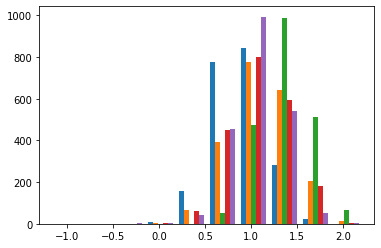

In [103]:
plt.hist(np.log1p(train_labels_[:,1]))

Text(0.5, 0.98, 'True vs Predictions for each target')

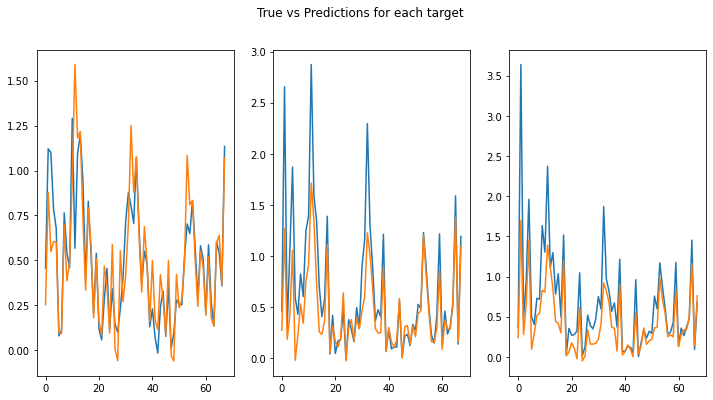

In [126]:
idx = np.random.randint(2096)

fig, ax = plt.subplots(1,3, figsize=(12, 6))
ax[0].plot(train_labels_[idx, :, 0])
ax[0].plot(oof_gru[idx, :, 0])
ax[1].plot(train_labels_[idx, :, 1])
ax[1].plot(oof_gru[idx, :, 1])
ax[2].plot(train_labels_[idx, :, 3])
ax[2].plot(oof_gru[idx, :, 3])
fig.suptitle('True vs Predictions for each target')